# Training ANN model on data

    Find best Dropout rate

In [1]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

import keras
from keras.models import Sequential # to initialise the NN
from keras.layers import Dense # to create layers
from keras.layers import Dropout
from keras import initializers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

  Using cached pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl (10.1 MB)
  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 6.8 MB 18.2 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
     |████████████████████████████████| 300 kB 98.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=5c0a813bf182b9346f34e93f0c723de990e40048f79c1058ea800dc06ef63756
  Stored in directory: /home/ec2-user/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


Using TensorFlow backend.


In [2]:
dropout_range = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


for i in dropout_range:
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # 2018 data
    data = data.loc[data.index > 2018100000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(method = 'ffill', inplace = True)
    y.fillna(method = 'ffill', inplace = True)

    X = X.round(20)
    
    # divide data into train and test with 10% test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    def regressor_tunning(n_hidden = 5, 
                          n_neurons = 40, 
                          kernel_initializer = "he_normal",
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = i))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = i))
        model.add(Dense(units = 1, activation = 'linear'))
        optimizer = optimizers.Adamax(lr = 0.001)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model

    tscv = TimeSeriesSplit(n_splits = 10)
    hist_list = pd.DataFrame()
    count = 1
    
    regressor = regressor_tunning()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 100)
          hist_list = hist_list.append(hist.history, ignore_index = True)
          print(count)
          count = count + 1

    a = []
    b = []
    
    for i in range(len(hist_list.mse)):
        a.append(np.mean(hist_list.mse[i]))
        b.append(np.mean(hist_list.mae[i]))
      
    mse_cv.append(np.mean(a))
    mae_cv.append(np.mean(b))
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)


/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 5s 13ms/step - loss: 14032.6853 - mse: 14032.6846 - mae: 112.9232
Epoch 2/100
366/366 [==============================] - 0s 689us/step - loss: 13231.6612 - mse: 13231.6611 - mae: 109.3648
Epoch 3/100
366/366 [==============================] - 0s 552us/step - loss: 10478.5939 - mse: 10478.5938 - mae: 95.7273
Epoch 4/100
366/366 [==============================] - 0s 774us/step - loss: 3994.0876 - mse: 3994.0879 - mae: 47.6605
Epoch 5/100
366/366 [==============================] - 0s 588us/step - loss: 1313.1151 - mse: 1313.1152 - mae: 25.9968
Epoch 6/100
366/366 [==============================] - 0s 550us/step - loss: 1220.2553 - mse: 1220.2554 - mae: 22.6811
Epoch 7/100
366/366 [==============================] - 0s 481us/step - loss: 1220.6367 - mse: 1220.6365 - mae: 22.9965
Epoch 8/100
366/366 [==============================] - 0s 248us/step - loss: 1222.7385 - mse: 1222.7383 - mae: 23.5567
Epoch 9/100
366/366 [====================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 2s 4ms/step - loss: 14135.3664 - mse: 14135.3633 - mae: 113.3681
Epoch 2/100
366/366 [==============================] - 0s 269us/step - loss: 13862.5151 - mse: 13862.5127 - mae: 112.1801
Epoch 3/100
366/366 [==============================] - 0s 261us/step - loss: 12747.1319 - mse: 12747.1328 - mae: 107.1026
Epoch 4/100
366/366 [==============================] - 0s 276us/step - loss: 8986.1059 - mse: 8986.1064 - mae: 87.3621
Epoch 5/100
366/366 [==============================] - 0s 353us/step - loss: 2683.7284 - mse: 2683.7288 - mae: 37.6604
Epoch 6/100
366/366 [==============================] - 0s 318us/step - loss: 1324.1287 - mse: 1324.1288 - mae: 25.5564
Epoch 7/100
366/366 [==============================] - 0s 375us/step - loss: 1239.8355 - mse: 1239.8354 - mae: 22.0940
Epoch 8/100
366/366 [==============================] - 0s 455us/step - loss: 1256.9552 - mse: 1256.9552 - mae: 23.7923
Epoch 9/100
366/366 [====================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 2s 6ms/step - loss: 14029.3715 - mse: 14029.3730 - mae: 112.9020
Epoch 2/100
366/366 [==============================] - 0s 719us/step - loss: 13252.3109 - mse: 13252.3105 - mae: 109.4186
Epoch 3/100
366/366 [==============================] - 0s 690us/step - loss: 10883.1334 - mse: 10883.1338 - mae: 97.8343
Epoch 4/100
366/366 [==============================] - 0s 717us/step - loss: 4534.4065 - mse: 4534.4072 - mae: 54.2460
Epoch 5/100
366/366 [==============================] - 0s 1ms/step - loss: 1452.5355 - mse: 1452.5355 - mae: 26.8461
Epoch 6/100
366/366 [==============================] - 0s 885us/step - loss: 1550.9863 - mse: 1550.9865 - mae: 27.1099
Epoch 7/100
366/366 [==============================] - 0s 805us/step - loss: 1568.5540 - mse: 1568.5541 - mae: 25.0518
Epoch 8/100
366/366 [==============================] - 0s 1ms/step - loss: 1429.4762 - mse: 1429.4761 - mae: 24.7997
Epoch 9/100
366/366 [=========================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 2s 6ms/step - loss: 14091.3373 - mse: 14091.3379 - mae: 113.1806
Epoch 2/100
366/366 [==============================] - 0s 799us/step - loss: 13692.2381 - mse: 13692.2393 - mae: 111.4015
Epoch 3/100
366/366 [==============================] - 0s 907us/step - loss: 12382.6844 - mse: 12382.6846 - mae: 105.3916
Epoch 4/100
366/366 [==============================] - 0s 614us/step - loss: 8765.0165 - mse: 8765.0166 - mae: 85.7758
Epoch 5/100
366/366 [==============================] - 0s 697us/step - loss: 3253.4128 - mse: 3253.4128 - mae: 42.7888
Epoch 6/100
366/366 [==============================] - 0s 707us/step - loss: 1869.8111 - mse: 1869.8113 - mae: 31.4394
Epoch 7/100
366/366 [==============================] - 0s 423us/step - loss: 1744.5770 - mse: 1744.5769 - mae: 29.2801
Epoch 8/100
366/366 [==============================] - 0s 643us/step - loss: 1784.8705 - mse: 1784.8702 - mae: 29.3667
Epoch 9/100
366/366 [====================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 2s 6ms/step - loss: 14119.3226 - mse: 14119.3223 - mae: 113.3042
Epoch 2/100
366/366 [==============================] - 0s 1ms/step - loss: 13825.6857 - mse: 13825.6846 - mae: 111.9832
Epoch 3/100
366/366 [==============================] - 0s 955us/step - loss: 12801.4407 - mse: 12801.4385 - mae: 107.3151
Epoch 4/100
366/366 [==============================] - 0s 1ms/step - loss: 9558.4527 - mse: 9558.4531 - mae: 90.3831
Epoch 5/100
366/366 [==============================] - 0s 1ms/step - loss: 4135.5307 - mse: 4135.5303 - mae: 50.9844
Epoch 6/100
366/366 [==============================] - 0s 759us/step - loss: 2458.1001 - mse: 2458.1003 - mae: 37.0518
Epoch 7/100
366/366 [==============================] - 0s 814us/step - loss: 2287.0752 - mse: 2287.0750 - mae: 33.9292
Epoch 8/100
366/366 [==============================] - 0s 1ms/step - loss: 2229.8725 - mse: 2229.8723 - mae: 33.3672
Epoch 9/100
366/366 [============================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 1s 4ms/step - loss: 14118.4173 - mse: 14118.4170 - mae: 113.2904
Epoch 2/100
366/366 [==============================] - 0s 265us/step - loss: 13882.7804 - mse: 13882.7803 - mae: 112.2386
Epoch 3/100
366/366 [==============================] - 0s 254us/step - loss: 13150.4032 - mse: 13150.4033 - mae: 108.8474
Epoch 4/100
366/366 [==============================] - 0s 291us/step - loss: 11202.8969 - mse: 11202.8975 - mae: 99.1397
Epoch 5/100
366/366 [==============================] - 0s 248us/step - loss: 6684.7771 - mse: 6684.7773 - mae: 70.1591
Epoch 6/100
366/366 [==============================] - 0s 243us/step - loss: 3467.8968 - mse: 3467.8970 - mae: 44.0813
Epoch 7/100
366/366 [==============================] - 0s 327us/step - loss: 3080.4642 - mse: 3080.4641 - mae: 40.2843
Epoch 8/100
366/366 [==============================] - 0s 271us/step - loss: 2958.0600 - mse: 2958.0601 - mae: 41.0128
Epoch 9/100
366/366 [==================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 1s 4ms/step - loss: 14142.8622 - mse: 14142.8633 - mae: 113.4109
Epoch 2/100
366/366 [==============================] - 0s 229us/step - loss: 14030.5634 - mse: 14030.5654 - mae: 112.9224
Epoch 3/100
366/366 [==============================] - 0s 189us/step - loss: 13798.7848 - mse: 13798.7842 - mae: 111.8882
Epoch 4/100
366/366 [==============================] - 0s 253us/step - loss: 13219.1947 - mse: 13219.1953 - mae: 109.2001
Epoch 5/100
366/366 [==============================] - 0s 259us/step - loss: 11631.4020 - mse: 11631.4014 - mae: 101.8004
Epoch 6/100
366/366 [==============================] - 0s 225us/step - loss: 8673.4660 - mse: 8673.4668 - mae: 84.3977
Epoch 7/100
366/366 [==============================] - 0s 210us/step - loss: 4734.4418 - mse: 4734.4414 - mae: 55.1833
Epoch 8/100
366/366 [==============================] - 0s 208us/step - loss: 3746.2536 - mse: 3746.2534 - mae: 45.3955
Epoch 9/100
366/366 [==============

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
366/366 [==============================] - 1s 4ms/step - loss: 14153.2121 - mse: 14153.2129 - mae: 113.4412
Epoch 2/100
366/366 [==============================] - 0s 323us/step - loss: 13995.2675 - mse: 13995.2676 - mae: 112.7808
Epoch 3/100
366/366 [==============================] - 0s 246us/step - loss: 13781.6651 - mse: 13781.6650 - mae: 111.7864
Epoch 4/100
366/366 [==============================] - 0s 272us/step - loss: 13353.1639 - mse: 13353.1641 - mae: 109.8217
Epoch 5/100
366/366 [==============================] - 0s 208us/step - loss: 12492.9868 - mse: 12492.9863 - mae: 105.6710
Epoch 6/100
366/366 [==============================] - 0s 283us/step - loss: 10906.7870 - mse: 10906.7871 - mae: 96.7866
Epoch 7/100
366/366 [==============================] - 0s 198us/step - loss: 8239.4073 - mse: 8239.4082 - mae: 80.3700
Epoch 8/100
366/366 [==============================] - 0s 225us/step - loss: 5701.5561 - mse: 5701.5562 - mae: 62.5905
Epoch 9/100
366/366 [============

In [3]:
data.head()

,Ren_R,APXP,Rene,TSDF,NIV,Im_Pr,In_gen,LOLP,PrevDay,PrevWeek,DA_margin,DA_imb,DA_price_france,ratio_offers_vol,DA_imb_France,Offers
0,0.729581,49.00,10379.138,21302.0,-173.0882,55.33220,1204.0,0.0,91.0,158.5,32390.0,-381.0,51.61,0.019201,0.774709,92.5
1,0.736864,54.19,10107.092,21117.0,-21.8796,43.18000,822.0,0.0,91.0,158.5,32259.0,34.0,69.13,0.015190,0.782172,92.5
2,0.751204,54.19,10107.092,21150.0,-25.4302,43.18000,594.0,0.0,220.0,158.5,31070.0,317.0,69.13,0.014307,0.782172,92.5
3,0.743394,60.94,9823.762,21713.0,156.0437,76.00000,908.0,0.0,160.0,158.5,29577.0,1431.0,77.32,0.017871,0.852149,180.0
4,0.743207,60.94,9823.762,21715.0,494.8151,81.91105,982.0,0.0,160.0,158.5,27346.0,2266.0,77.32,0.018758,0.852149,92.5


In [8]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = dropout_range)

results

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.00,41.066671,23.985321,36.115624,27.429656,63.546892,50.349729,29.007947,23.549009
0.01,41.926866,24.517269,34.870727,26.394013,62.813810,49.070850,27.455635,22.554548
0.05,41.803615,24.571262,31.334806,21.681109,64.305176,52.131892,21.165549,16.525421
0.10,42.986883,25.595825,32.783129,23.929774,65.364504,52.749160,23.093497,19.050302
0.20,44.463619,26.872412,31.703298,22.549635,66.120346,53.723867,20.858061,17.271458
0.30,46.152566,28.392551,31.664070,23.540842,62.778650,50.906835,22.474024,18.907446
0.40,48.017936,29.921825,31.224153,23.029258,63.855656,51.994308,21.204723,18.125122
0.50,50.848119,32.438190,30.944353,22.472534,64.920873,53.051280,20.151304,17.295180


In [9]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [6]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.0,41.066671,23.985321,36.115624,27.429656,63.546892,50.349729,29.007947,23.549009
0.01,41.926866,24.517269,34.870727,26.394013,62.813810,49.070850,27.455635,22.554548
0.05,41.803615,24.571262,31.334806,21.681109,64.305176,52.131892,21.165549,16.525421
0.1,42.986883,25.595825,32.783129,23.929774,65.364504,52.749160,23.093497,19.050302
0.2,44.463619,26.872412,31.703298,22.549635,66.120346,53.723867,20.858061,17.271458
0.3,46.152566,28.392551,31.664070,23.540842,62.778650,50.906835,22.474024,18.907446
0.4,48.017936,29.921825,31.224153,23.029258,63.855656,51.994308,21.204723,18.125122
0.5,50.848119,32.438190,30.944353,22.472534,64.920873,53.051280,20.151304,17.295180


<IPython.core.display.Javascript object>


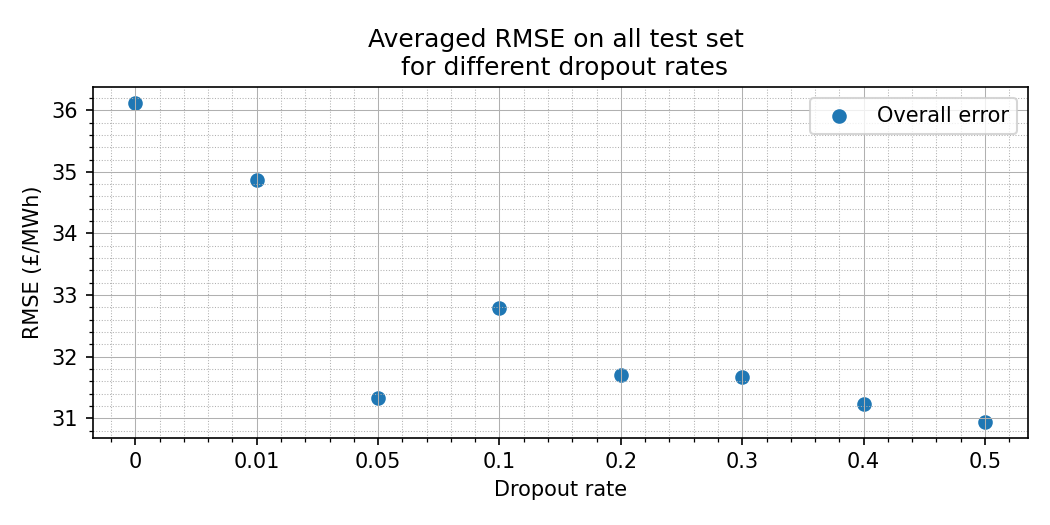

<IPython.core.display.Javascript object>


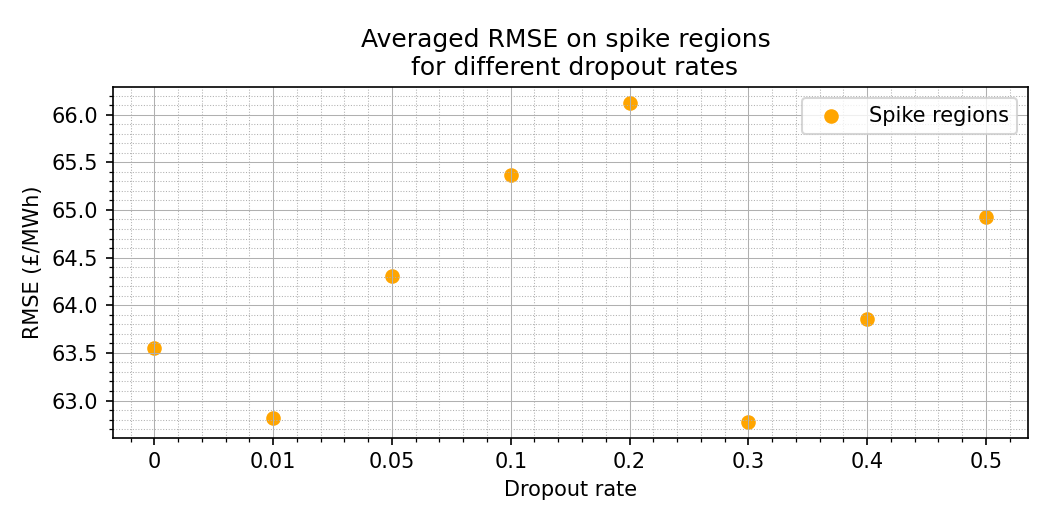

<IPython.core.display.Javascript object>


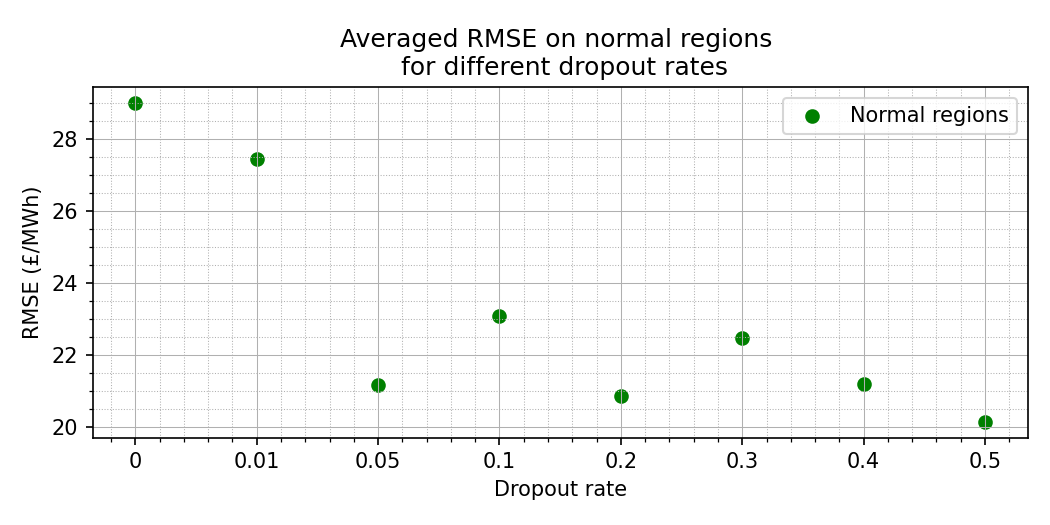

In [10]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on all test set \n for different dropout rates')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7], y = rmse_gen, label = 'Overall error')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Dropout rate')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], dropout_range)
plt.tight_layout()
plt.savefig('Dropout_rate_RMSE_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on spike regions \n for different dropout rates')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7], y =rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Dropout rate')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], dropout_range)
plt.tight_layout()
plt.savefig('Dropout_rate_RMSE_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on normal regions \n for different dropout rates')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7], y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Dropout rate')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], dropout_range)
plt.tight_layout()
plt.savefig('Dropout_rate_RMSE_normal.png')

<IPython.core.display.Javascript object>


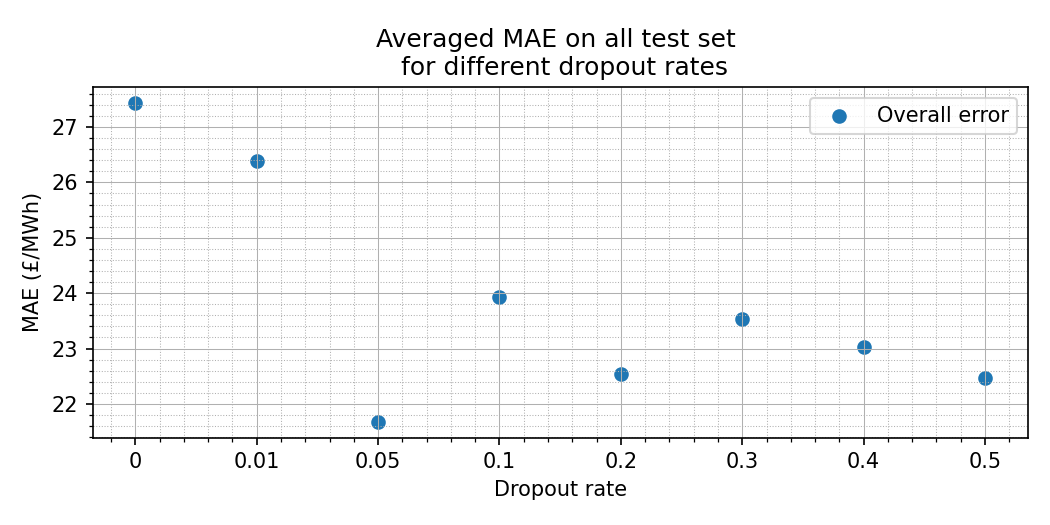

<IPython.core.display.Javascript object>


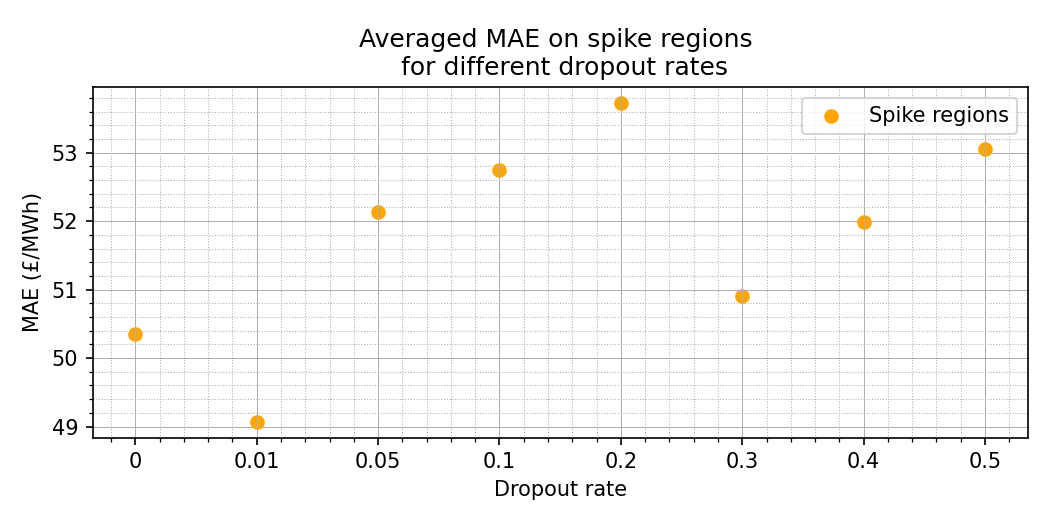

<IPython.core.display.Javascript object>


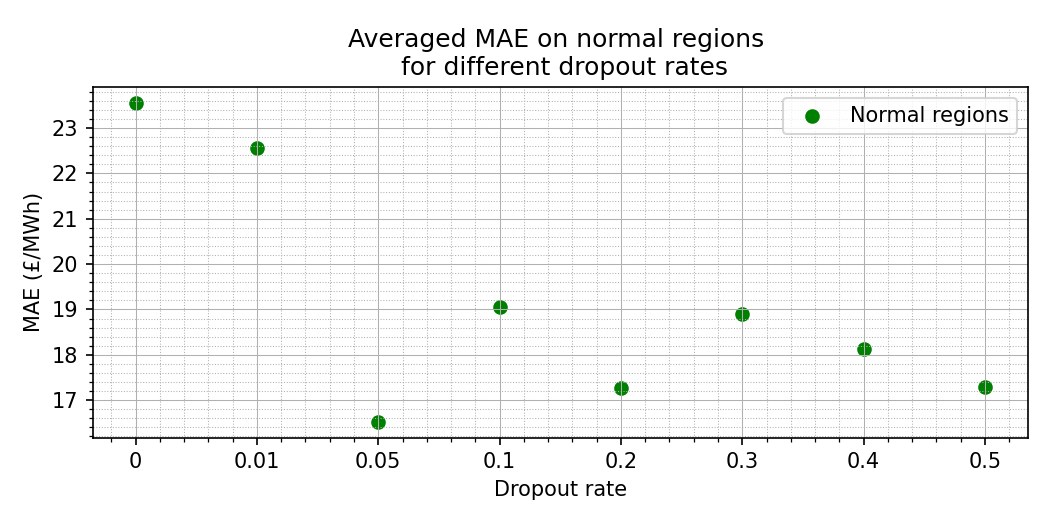

In [12]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on all test set \n for different dropout rates')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7], y = mae_gen, label = 'Overall error')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Dropout rate')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], dropout_range)
plt.tight_layout()
plt.savefig('Dropout_rate_MAE_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on spike regions \n for different dropout rates')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7], y =mae_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Dropout rate')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], dropout_range)
plt.tight_layout()
plt.savefig('Dropout_rate_MAE_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on normal regions \n for different dropout rates')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7], y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Dropout rate')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], dropout_range)
plt.tight_layout()
plt.savefig('Dropout_rate_MAE_normal.png')